### Clash Royale card balance analysis

This notebook provides a basic game balance analysis tutorial using a Kaggle dataset of Clash Royale card stats. Click "copy to drive" to edit and run the code.

**Learning goals:** Using the Pandas package to load and manipulate datasets. Using basic linear regression from Scikit Learn for game balance analysis and design.

**Before starting:** Make sure you've played Clash Royale to at least the second arena and understand the basic game mechanics. Also watch Stefan Engblom's [GDC talk](https://www.youtube.com/watch?v=bHLQQh8Ctu4) on balancing Clash Royale.

**A note on the exercises:** Think of this as a puzzle game: Try to solve the exercises without showing the hints and solutions, which are hidden by default. Add a new code cell below each exercise for your attempt. You may copy-paste code from earlier cells to get started.

This notebook is part of Aalto University's Game Analysis course, inspired by the GDC talk above and this [Hearthstone data science tutorial](https://www.kaggle.com/ismailgungor/data-science-tutorial-with-hearthstone-cards)

First, the standard imports (Numpy and PyPlot) plus Pandas for dataset utilities.

In [1]:
import numpy as np   
import matplotlib.pyplot as plt
import pandas as pd  #.csv file utils etc.

Fetch the dataset from the course's Github, if not already fetched (avoid duplicates if this code is run multiple times). Note that we use the "!" prefix to use the Linux wget command line utility. 

In [2]:
#import file path utilities
from os import path
#check if the dataset already exists 
if not path.exists("dataset.csv"):
  #fetch the dataset from the url. 
  !wget -O dataset.csv https://raw.githubusercontent.com/PerttuHamalainen/GameAnalysis/master/datasets/clash_wiki_dataset.csv  
  

--2020-12-07 18:23:55--  https://raw.githubusercontent.com/PerttuHamalainen/GameAnalysis/master/datasets/clash_wiki_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4925 (4.8K) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>]   4.81K  --.-KB/s    in 0s      

2020-12-07 18:23:55 (27.8 MB/s) - ‘dataset.csv’ saved [4925/4925]



Create a Pandas DataFrame obhject from the dataset and show the first few rows using the DataFrame's head() utility.

In [3]:
data = pd.read_csv("dataset.csv",encoding='iso-8859-1')
data.head()

,Card,Card Level (Spawn Level),Cost,Count,Crown Tower Damage,Damage,Damage per second,Death Damage,Health (+Shield),Hit Speed,Level,Maximum Spawned,Radius,Range,Spawn DPS,Spawn Damage,Spawn Health,Spawn Speed,Spawner Health,Troop Spawned,Type
0,Archers,NaN,3.0,2,NaN,86,71,0.0,254,1.2,9.0,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,Troops and Defenses
1,Baby Dragon,NaN,4.0,1,NaN,133,83,0.0,"1,064",1.6,4.0,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,Troops and Defenses
2,Balloon,NaN,5.0,1,NaN,798,266,272.0,"1,396",3,4.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Troops and Defenses
3,Bandit,NaN,3.0,1,NaN,160,160,0.0,780,1,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Troops and Defenses
4,Barbarians,NaN,5.0,4,NaN,159,106,0.0,636,1.5,9.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Troops and Defenses


We see that the data is not super clean: There are many card types and for some cards, some values are NaN:s (which here signal that the value is not defined). There are also some other exceptions such as the damage per second, which is NaN for spells and numeric for other cards, except Inferno tower and Inferno dragon, where it is given as a range of values. To help dealing with this, we first define a helper function for getting a clean subset where rows containing non-numeric values are removed.
 

In [4]:
#Returns a new Pandas dataframe consisting of only the given columns.
#Rows with non-numeric values are removed. 
#The columns argument can be a single column such as "Cost" 
#or a list such as ["Cost","Damage"]
#TODO: This code is ugly, figure out a more concise way.
def getCleanSubset(data,columns):
  subset=data[columns]  
  #Also add the card names for easier visualization
  subset["Card"]=data["Card"]  
  #remove rows with missing values
  subset=subset.dropna(axis="index") 
  #remove rows with something that cannot be expressed as a number
  if not isinstance(columns,list):
    #if the columns is not a list (i.e., it is a single column),
    #wrap it into a list for the loop below
    columns=[columns]
  for column in columns:
    #Remove rows that cannot be converted to a numeric value
    subset=subset[pd.to_numeric(subset[column], errors='coerce').notnull()]
    #Convert to numeric value
    subset[column]=pd.to_numeric(subset[column], errors='coerce')
  return subset

#Test the function
print(getCleanSubset(data,["Cost","Damage per second"]))

    Cost  Damage per second              Card
0    3.0                 71           Archers
1    4.0                 83       Baby Dragon
2    5.0                266           Balloon
3    3.0                160            Bandit
4    5.0                106        Barbarians
5    2.0                 67              Bats
6    4.0                  0        Battle Ram
7    5.0                110        Bomb Tower
8    3.0                142            Bomber
9    5.0                 95            Bowler
10   3.0                158            Cannon
11   5.0                169       Cannon Cart
12   4.0                147       Dark Prince
13   3.0                132       Dart Goblin
14   4.0                111    Electro Wizard
15   6.0                169  Elite Barbarians
16   5.0                116       Executioner
17   2.0                  0      Fire Spirits
18   5.0                140             Giant
19   6.0                114    Giant Skeleton
21   2.0                 96       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### Analyzing cost and benefit of cards using scatter plots and correlation

In Clash Royale, the player has a deck of 8 cards, and deploying each card costs elixir, which is only slowly replenished. The key to winning is investing elixir smartly, getting maximum benefits for each drop of elixir spent. Thus, cards with a high elixir cost are typically more powerful.

The basic problem of balancing the card stats is to keep the cost/benefit ratios of the cards constant so that no card provides a clearly better or worse ratio. This is important for the meta game (i.e., how the players choose and optimize their card decks) to have variety, i.e., all cards to have approximately similar use rates. If there were clearly superior cards, every player would use them and the meta would become boring.

To investigate this, let's plot some card stats with respect to the elixir cost and their correlation coefficients. A correlation of 1 would mean that the stat in question is directly proportional to cost. Correlation of 0 indicates no relation, and negative correlations indicate inverse proportionality.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Correlation: 0.542788417763317


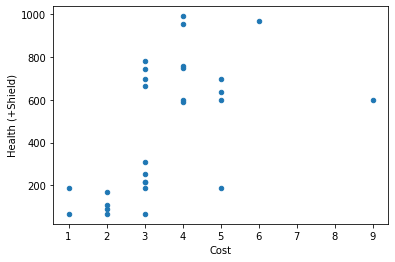

In [ ]:
subset=getCleanSubset(data,["Health (+Shield)","Cost"])
subset.plot.scatter(x="Cost",y="Health (+Shield)")
print("Correlation:",subset["Cost"].corr(subset["Health (+Shield)"]))

###Exercise: Do the same with some other values

Add a new code cell below this text, copy-paste the code above to it, and edit it. Which values are highly correlated with the cost?

Optional: Annotate the scatterplot with card names. See, for example, https://stackoverflow.com/questions/15910019/annotate-data-points-while-plotting-from-pandas-dataframe/15911372#15911372

####Solution (expand to show code)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Correlation: 0.3795885518967999


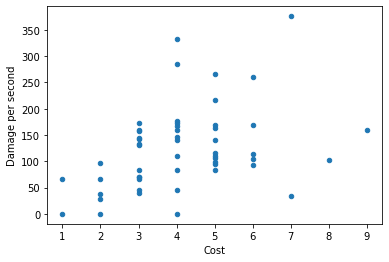

In [ ]:
subset=getCleanSubset(data,["Damage per second","Cost"])
subset.plot.scatter(x="Cost",y="Damage per second")
print("Correlation:",subset["Cost"].corr(subset["Damage per second"]))

###Calculating benefit based on multiple values
The code below shows how to perform math on Pandas dataframe columns and add the results as a new column. We call this column "Benefit" and calculate it as the sum of damage per second and health. This yields a tiny bit better correlation (to be improved in the exercise that follows).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Correlation: 0.5556838560806563


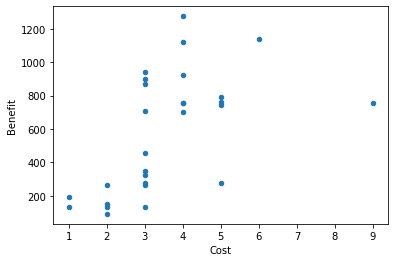

In [ ]:
#Example of adding a new column that combines existing ones
s=getCleanSubset(data,["Damage per second","Health (+Shield)","Cost"])
s["Benefit"]=s["Damage per second"]+s["Health (+Shield)"]
s.plot.scatter(x="Cost",y="Benefit")
print("Correlation:",s["Cost"].corr(s["Benefit"]))

###Exercise: Improve the benefit calculation
Improve the code above by figuring out how to combine at least three stats. 

How close to 1 can you get the correlation? If you can get a correlation of 1, you have reverse-engineered how Clash Royale designers balance the stats.


####Hint: (expand this section to show)


Try using "Damage per second", "Count", and "Health (+Shield)". Note that you can use all basic math operations such as multiplication and addition. Consider that the total damage caused by a troop depends on both damage per second and the troop's lifespan, and the lifespan depends on health.

####Solution: (expand this section to show)

In this example solution (which is not the only possible one), we multiply the DPS, count, and health together. This way, the benefit is calculated as the total damage the a troop (or a swarm of "Count" units) might deal to an opponent. 

Of course, this is still a simple approximation, omitting details like a swarm being weak against splash damage.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Correlation: 0.7285591563261166


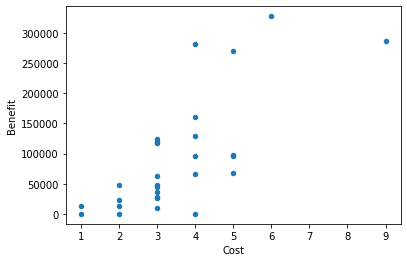

In [ ]:
s=getCleanSubset(data,["Damage per second","Count","Health (+Shield)","Cost"])
s["Benefit"]=s["Count"]*s["Damage per second"]*s["Health (+Shield)"]
s.plot.scatter(x="Cost",y="Benefit")
print("Correlation:",s["Cost"].corr(s["Benefit"]))

###Linear models

Above, we've only used scatterplots and correlation. These can indicate which parameters are good for predicting benefit linearly based on cost. However, these don't directly answer questions like "If I have a new card with these stats, what should its elixir cost be?" or "What would be reasonable values for some stats if other stats are known?".

To answer such questions, one can try a linear model from the Scikit Learn package. The linear model is of form ```ax+b=y```. In our case, x is benefit and y is cost, and model estimates the a and b. 

Note: To allow modeling, we need to first convert the Pandas dataframe columns to Numpy arrays. You can ignore the details of how this is done in the convert() function, but if you'd like to learn about Numpy arrays and reshaping, see https://numpy.org/doc/stable/user/quickstart.html

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


a,b [[1.25512573e-05]] [2.37290664]


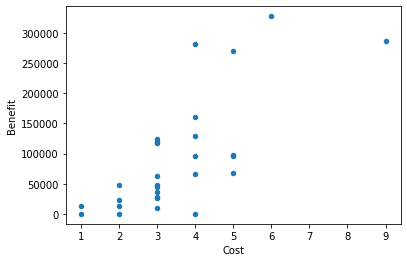

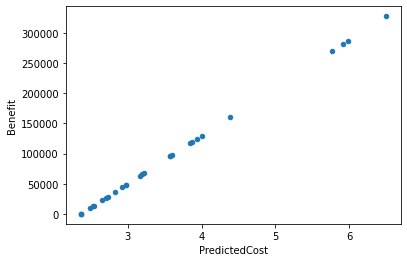

In [ ]:
#Import the tool we need
from sklearn.linear_model import LinearRegression
#A converter function that accepts Pandas dataframes and 
#plain floating point or integer numbers and returns 2D Numpy arrays
#which are expected by sklearn
def convert(x):
  if isinstance(x,pd.DataFrame) or isinstance(x,pd.Series):
    return x.to_numpy().reshape([-1,1])
  elif isinstance(x,float) or isinstance(x,int):
    return np.array(x).reshape([-1,1])
  else:
    print("Can't convert this data type")
#Calculate benefit as above
s=getCleanSubset(data,["Damage per second","Count","Health (+Shield)","Cost"])
s["Benefit"]=s["Count"]*s["Damage per second"]*s["Health (+Shield)"]
#Create a new model
model=LinearRegression() 
#Fit the model to data so that it predicts cost from benefit.
model.fit(convert(s["Benefit"]),convert(s["Cost"]))
#Print the regression coefficients a,b
print("a,b",model.coef_,model.intercept_)
#Now, we can predict the cost for some new benefit value. 
s["PredictedCost"]=model.predict(convert(s["Benefit"]))
#Plot both actual and predicted costs
s.plot.scatter(x="Cost",y="Benefit")
s.plot.scatter(x="PredictedCost",y="Benefit")

###Exercise: use the model to calculate and print elixir cost for a hypothetical new card with some DPS, health, and count values.

Note: after you've run the code above, the variables are also available in all the cells below it, so you can directly use ```model.predict(benefit)```. Also remember to use the convert() function.


####Solution (expand to show):

In [ ]:
#Define the parameters
dps=1000
health=100
count=2
#Compute the benefit similar to above
benefit=dps*health*count
#Print the predicted cost
print("Predicted elixir cost",model.predict(convert(benefit)))

Predicted elixir cost [[4.8831581]]


###Exercise: find cards that violate the model. What do these tell about the model? 

Basically, the cards that violate the model should give you insights of which mechanics and dynamics (e.g., card vs. card interactions) your model is not capturing.

####Hint (expand to show)


For example, you can calculate the absolute value of the cost prediction error for each card as ```np.abs(s["PredictedCost"]-s["Cost"])```. Then, sort the dataframe based on this (google Pandas sort) and print the head (see the beginning of this notebook).

Another way could be to calculate cost/benefit ratios and sort the cards based on it. Cards with very low or high ratio violate your model.

####Solution (expand to show)

The code below shows that the 5 cards with highest cost prediction error are Three Musketters, Lumberjack, Witch, Battle Ram, and Skeletons. This is not very surprising: The model does not take into account special abilities like Lumberjack's rage and the Witch spawning skeletons. Three musketeers and skeletons are swarm troops which have some additional dynamics like being able to be split onto two attack lanes. Battle ram's benefit is zero, meaning that there's probably an error in the data.  

In [ ]:
s["PredictionErrors"]=s["PredictedCost"]-s["Cost"]
s["AbsPredictionErrors"]=np.abs(s["PredictionErrors"])
sorted=s.sort_values(by="AbsPredictionErrors",ascending=False)
sorted.head()

,Damage per second,Count,Health (+Shield),Cost,Card,Benefit,PredictedCost,PredictionErrors,AbsPredictionErrors
52,160,3,598,9.0,Three Musketeers,287040,5.975620,-3.024380,3.024380
34,285,1,990,4.0,Lumberjack,282150,5.914244,1.914244,1.914244
54,98,1,696,5.0,Witch,68208,3.229003,-1.770997,1.770997
6,0,1,756,4.0,Battle Ram,0,2.372907,-1.627093,1.627093
47,67,3,67,1.0,Skeletons,13467,2.541934,1.541934,1.541934


###Exercise: Calculate health of a hypothetical new card based on some dps, count, and cost values

####Hint (expand to show)

The linear model gives us a and b for the equation ax+b=y. The y is the cost and x is the benefit. You can substitute the benefit formula used above into ax+b=y then solve any variable from others through basic algebraic manipulation. 

####Solution (expand to show)

In [ ]:
#Define the known parameters
dps=1000
count=2
cost=4
#Solve the following for health: dps*count*health*a+b=cost
#=> health=(cost-b)/(dps*count*a)
#The a and b are given by the model as above
a=model.coef_
b=model.intercept_
#Print the predicted health
health=(cost-b)/(dps*count*a)
print("Predicted health",health)

Predicted health [[64.81794302]]


Try different values! What happens to health, for example, if you increase dps or count?

###Advanced exercise:
The dataset we use is old and does not include all the cards of the current Clash Royale version. Write Python code that scrapes the current stats from a website like https://clashroyale.fandom.com/wiki/Cards 



###Advanced exercise:

Implement a simulation of card vs. card battles. Use the simulation to analyze intransitive balance, i.e., "rock paper scissors" balance: Every card should win in some situations but also have one or multiple counters. Write a script that highlights which cards violate this rule. Such a script could be valuable for automatically testing that the balance is not broken.

###Advanced exercise: 
Extend the benefit calculation to all card types. You may need to loop over all cards in a for loop and do the benefit calculation differently for each type. Also try to incorporate mechanics like death damage and ranged attacks.

How close to 1 can you get the correlation?